In [13]:
CONF = {
  "BlockchainParameters": {
    "GenesisBlockSize": 0, 
    "BatchSize": {
      "AbsoluteMaxBytes": 10485760,  # Bytes
      "MaxMessageCount": 100000
    }, 
    "BatchTimeout": 600, #Seconds
  }, 
  "BlockHeaders": { # Bytes
    "MetadataSize": 64, 
    "HeaderSize": 128
  },
  "TransactionFields": {#Bytes
    "R4": 128, 
    "E4": 512, 
    "H4": 64, 
    "P4": 256, 
    "S4": 256
  },
  "EndorsementPolicy": 1/2
}

CLOUD_PRICING = {
    "Storage": {
      "Pricing": 0.045
    }, 
    "NetworkThroughput": {
      "Pricing": 0.01
    }, 
    "VirtualMachine": {
      "FilePricing": "path", #null requires insert manual values InstancesTypes
      # "InstancesTypes": [
      #   {"VCPU": 2,  "Pricing": 0.0388},
      #   {"VCPU": 4,  "Pricing": 0.0776},
      #   {"VCPU": 8,  "Pricing": 0.1552},
      #   {"VCPU": 16,  "Pricing": 0.3104},
      # ]
      
    }, 
    "Additional": 0
  }


### ToDo

<input type="checkbox" disabled />     Incluir verificação  não houver modelo com quantiadade de cpus suficiene ex.: Azure com até 72vcpu <br>
<input type="checkbox" disabled checked />     Verificar todas as metricas de calculo. Ex.: Storage /Mes. <br> 
<input type="checkbox" disabled checked />Network ok pois é por GB independente

### Links de plots
https://github.com/norvig/pytudes

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd

#import predict

In [15]:
#predict.py
TRANSACTION_SIZE     =  np.sum(np.array([fields_values for fields_values in CONF['TransactionFields'].values()]))
BLOCK_HEADERS_SIZE   =  np.sum(np.array([fields_values for fields_values in CONF['BlockHeaders'].values()]))

def calculate_size_total_transacoes(self, total_transactions:int, transation_size:int) -> int:
   self.size_total_transacoes = total_transactions * transation_size
   if self.size_total_transacoes > self.absolute_max_bytes:
      print('Undefined: size_total_transacoes > absolute_max_bytes')
      print('size_total_transacoes : ', self.size_total_transacoes)
      return -1
   return self.size_total_transacoes

class StorageDemand:
    def __init__(self):
        self.total_blocks = 0
        self.total_transactions = 0
        self.calculated_total_size_blocks = 0
        self.batch_type = ""
        self.period = 0

class CostPredict:
    def __init__(self):
        self.vm_pricing_hours            = CONF['Cloud']['VirtualMachine']['Pricing']
        self.vm_vcpu                     = CONF['Cloud']['VirtualMachine']['VCPU']
        self.storage_pricing             = CONF['Cloud']['Storage']['Pricing']
        self.network_throughput_pricing  = CONF['Cloud']['NetworkThroughput']['Pricing']
        self.additional                  = CONF['Cloud']['Additional']

In [16]:
def logistic_curve(t, P0, K, r, t0):
    return P0 + (K - P0) / (1 + np.exp(-r * (t - t0)))

# Dados de exemplo de tempo (t)
global PREDICT_TYPE
PREDICT_TYPE = 'YEAR' #'DAY':'WEEK':'MONTH':'YEAR'
A = 10 #10 ANOS EM DIAS 

t = np.linspace(0, A - 1, A)
print(len(t))

# Parâmetros da curva logística
P0 = 5  # Transações inicial
K = 1000  # Valor máximo transações estimado
r =  0.9 # Taxa de crescimento
t0 = A / 4     # Ponto de inflexão -> Meio

# Calcula a população usando a função da curva logística
global rate_transactions
AVG_RATE_TRANSACTIONS = logistic_curve(t, P0, K, r, t0)

AVG_RATE_TRANSACTIONS = np.array([50,100,150,200,250,320,370,550,750,1000])

10


In [17]:
# Cod Auxiliar
def simple_plot(x,y,line_label="", xlabel=f'Tempo ({PREDICT_TYPE})', ylabel="", title="", v_grid=True, tlabel_style="plain"):
    print(f'Ultimo valor "{line_label}" => {y[-1]}')
    fig, ax = plt.subplots()
    ax.plot(x,y,label=line_label)
    ax.ticklabel_format(style=tlabel_style)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(v_grid)
    return fig, ax

In [18]:
# # Dados de exemplo de tempo (t)
# global PREDICT_TYPE
# PREDICT_TYPE = 'MONTH' #'DAY':'WEEK':'MONTH':'YEAR'
# A = 168 

# t = np.linspace(0, A - 1, A)
# print(len(t))

# # Parâmetros da curva logística
# P0 = 5  # Transações inicial
# K = 5000  # Valor máximo transações estimado
# r =  0.05 # Taxa de crescimento
# t0 = A/4       # Ponto de inflexão -> Meio

# # Calcula a população usando a função da curva logística
# global rate_transactions
# AVG_RATE_TRANSACTIONS = logistic_curve(t, P0, K, r, t0)


Ultimo valor "Curva Logística (S)" => 1000


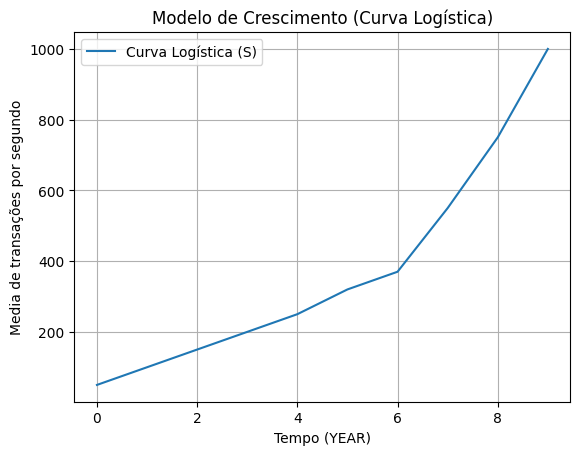

In [19]:
#Plotagem da curva logística
fig, ax = simple_plot(x= t,y= AVG_RATE_TRANSACTIONS, line_label= 'Curva Logística (S)', ylabel= 'Media de transações por segundo', title= 'Modelo de Crescimento (Curva Logística)')
plt.show()

In [20]:

def expand_transations_by_period(predict_type, rate_transations_per_second):
    SECONDS_PER_DAY  = 86400
    return {
    'DAY': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY,
    'WEEK': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 7,
    'MONTH': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 30,
    'YEAR': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 365
    }[predict_type](rate_transations_per_second)

total_transactions_by_period = expand_transations_by_period(PREDICT_TYPE, AVG_RATE_TRANSACTIONS)

In [21]:
endorsement_transations = total_transactions_by_period * CONF['EndorsementPolicy']

# Storage e Transações

Ultimo valor "Transações (Commited)" => 31536000000


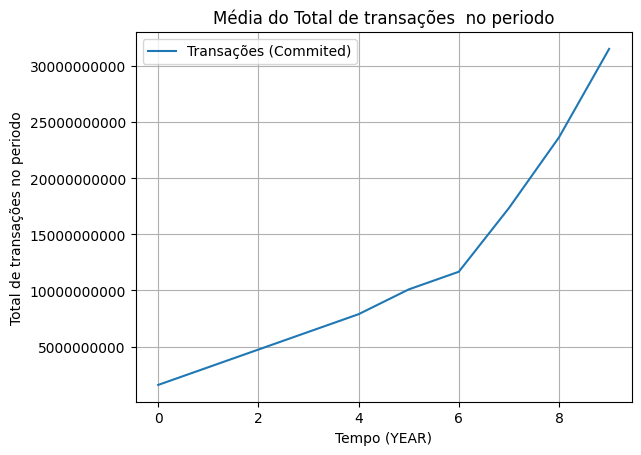

In [22]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = simple_plot(x= t, y= total_transactions_by_period, line_label= 'Transações (Commited)', ylabel= 'Total de transações no periodo', title= 'Média do Total de transações  no periodo')
plt.show()

Ultimo valor "Total Commited Transations" => 31536000000
Ultimo valor "Total Endorsement Transations" => 15768000000.0


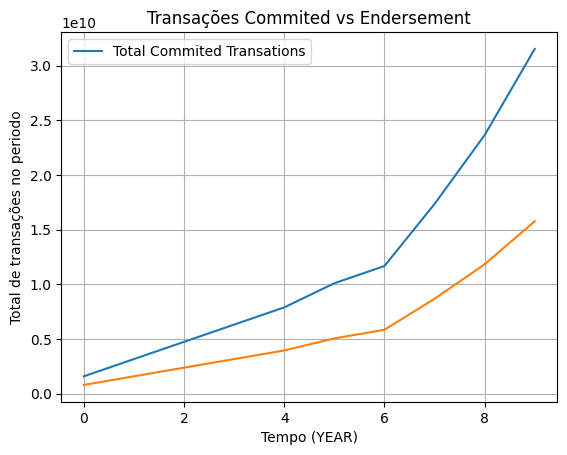

In [23]:
fig, ax = simple_plot(x= t, y= total_transactions_by_period, line_label='Total Commited Transations', ylabel= 'Total de transações no periodo', title= 'Transações Commited vs Endersement', tlabel_style='sci')
ax.plot(t, endorsement_transations, label='Total Endorsement Transations')
print(f'Ultimo valor "Total Endorsement Transations" => {endorsement_transations[-1]}')

plt.show()

In [24]:

#blockchain_predict = predict.blockchain_predict()


def estimate_blocks(avg_tps, total_transations_period):
    total_blocks = None
    batch_type  = ""
    #Qual o tempo necessário para fechar um bloco para max_message
    time_to_batch_messages = CONF['BlockchainParameters']['BatchSize']['MaxMessageCount'] / avg_tps

    #Quantas transações eu preciso para fechar um bloco para max_bytes
    aggregate_total_transations_if_batch_max_bytes = CONF['BlockchainParameters']['BatchSize']['AbsoluteMaxBytes'] / TRANSACTION_SIZE
    time_to_batch_bytes  = aggregate_total_transations_if_batch_max_bytes / avg_tps
    total_blocks = None
    
    if time_to_batch_messages >= CONF['BlockchainParameters']['BatchTimeout']  and \
            time_to_batch_bytes >=  CONF['BlockchainParameters']['BatchTimeout'] :

        #calcular por batchtimeout
        aggregate_total_transations_if_batch_timeout = CONF['BlockchainParameters']['BatchTimeout'] * avg_tps
        total_blocks = total_transations_period / aggregate_total_transations_if_batch_timeout
        batch_type = "batch_timeout"

    elif time_to_batch_messages < time_to_batch_bytes:
        total_blocks = total_transations_period / time_to_batch_messages
        batch_type = "batch_message"
        #batch messages
    
    elif time_to_batch_bytes    < time_to_batch_messages:
        total_blocks = total_transations_period / time_to_batch_bytes
        batch_type = "batch_bytes"
        #batch bytes
    else:
        raise Exception
        
    
    return total_blocks, batch_type

storage_demand = []


for i_period in range(0,A):
    avg_t = AVG_RATE_TRANSACTIONS[i_period]
    total_transations_by_period = total_transactions_by_period[i_period]
    print(avg_t)
    print(total_transations_by_period)

    i_storage_demand = StorageDemand()
    i_storage_demand.period                                         = i_period    
    i_storage_demand.total_transactions                             = total_transations_by_period
    i_storage_demand.total_blocks, i_storage_demand.batch_type      = estimate_blocks(avg_t, total_transations_by_period)
    i_storage_demand.calculated_total_size_blocks                   = (i_storage_demand.total_blocks * BLOCK_HEADERS_SIZE) + (i_storage_demand.total_transactions * TRANSACTION_SIZE)
    
    storage_demand.append(i_storage_demand)
    


50
1576800000
100
3153600000
150
4730400000
200
6307200000
250
7884000000
320
10091520000
370
11668320000
550
17344800000
750
23652000000
1000
31536000000


In [25]:
for s in storage_demand:
    atributos = vars(s)
    # Iterando sobre o dicionário e imprimindo os atributos
    for chave, valor in atributos.items():
        print(f"{chave}: {valor}")

total_blocks: 9142822.265625
total_transactions: 1576800000
calculated_total_size_blocks: 1919144221875.0
batch_type: batch_bytes
period: 0
total_blocks: 36571289.0625
total_transactions: 3153600000
calculated_total_size_blocks: 3841799287500.0
batch_type: batch_bytes
period: 1
total_blocks: 82285400.39062501
total_transactions: 4730400000
calculated_total_size_blocks: 5767965196875.0
batch_type: batch_bytes
period: 2
total_blocks: 146285156.25
total_transactions: 6307200000
calculated_total_size_blocks: 7697641950000.0
batch_type: batch_bytes
period: 3
total_blocks: 228570556.640625
total_transactions: 7884000000
calculated_total_size_blocks: 9630829546875.0
batch_type: batch_bytes
period: 4
total_blocks: 374490000.0
total_transactions: 10091520000
calculated_total_size_blocks: 12343190400000.0
batch_type: batch_bytes
period: 5
total_blocks: 500660947.26562506
total_transactions: 11668320000
calculated_total_size_blocks: 14284804021875.0
batch_type: batch_bytes
period: 6
total_blocks:

In [26]:
i_period           = np.array([s.period for s in storage_demand])
cumulative_blocks  = np.cumsum( np.array([s.total_blocks for s in storage_demand]) )

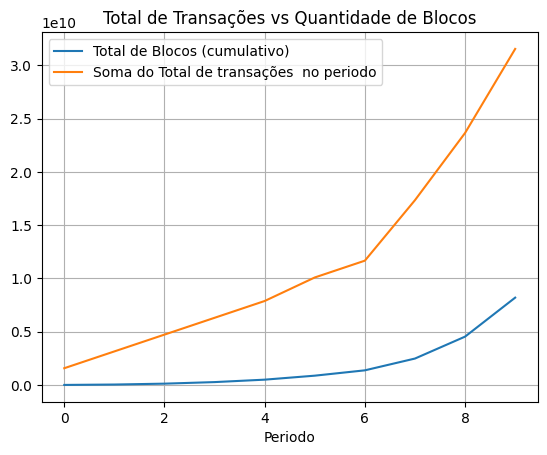

In [27]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()
ax.plot(i_period, cumulative_blocks, label='Total de Blocos (cumulativo)')

ax.plot(t, total_transactions_by_period, label='Soma do Total de transações  no periodo')


ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('')
plt.title('Total de Transações vs Quantidade de Blocos')
plt.legend()
plt.show()

In [28]:
BYTE_TO_GIGA =  1024 * 1024 * 1024
cumulative_size_GB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in storage_demand]) /  BYTE_TO_GIGA )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


135036.9343010243


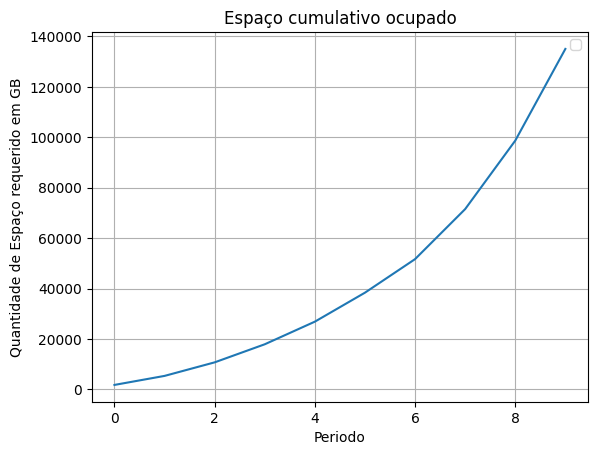

In [29]:
print(cumulative_size_GB[-1])
fig, ax = plt.subplots()
ax.plot(i_period, cumulative_size_GB, label='')

ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('Quantidade de Espaço requerido em GB')
plt.title('Espaço cumulativo ocupado')
plt.legend()
plt.show()

### Storage 

Estimativas criadas a partir da calculadora AWS. 
É importante ressaltar que cloud providers consideram 730 horas mês,
 isso significa dizer que uma semana, é em média cobrada 730 * 0,25, o que resulta em 182,5 ao contrário de 7 * 24 = 168

A justificativa é porque isso consegue minimizar as divergencias de meses com 28,29,30,31 dias

[Ir para](##CPU-PEER)

In [30]:
def convert_period_month(predict_type): #BASED AWS CALCULATOR
    VOLUME_MONTH_HOURS  = 730
    return {
    'DAY'   : 30 / VOLUME_MONTH_HOURS, #0,04109...
    'WEEK'  : ( VOLUME_MONTH_HOURS / 4 ) / VOLUME_MONTH_HOURS, # 0,25
    'MONTH' : VOLUME_MONTH_HOURS / VOLUME_MONTH_HOURS, # 1
    'YEAR'  : (VOLUME_MONTH_HOURS / VOLUME_MONTH_HOURS) * 12, #12 
    }[predict_type]


convert_period_pricing_month = convert_period_month(PREDICT_TYPE)
print()
total_storage_cost = cumulative_size_GB * (predict.CostPredict().storage_pricing  * convert_period_pricing_month)

NameError: name 'predict' is not defined

In [ ]:
# Plotagem da soma do toal transações estimada no periodo
print(total_storage_cost[-1])
fig, ax = plt.subplots()
ax.plot(i_period, total_storage_cost, label='storage_cost')

ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('')
plt.title('')
plt.legend()
plt.show()

NameError: name 'total_storage_cost' is not defined

# CPU

Analise conforme TPS

## CPU Ordering Service

In [ ]:
aggregate_total_required_vcpu_osn = np.array([])
vCPU_BASE     =  1
vCPU_BASE_TPS = 150 # 2vcpu = 200

ordering_transations = AVG_RATE_TRANSACTIONS

for tps in ordering_transations:
    target_required_vcpu  = vCPU_BASE

    required_vcpu_current_tps = tps / vCPU_BASE_TPS

    if int(required_vcpu_current_tps) > 1:
        target_required_vcpu = vCPU_BASE + (vCPU_BASE * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_osn = np.append(aggregate_total_required_vcpu_osn, target_required_vcpu)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


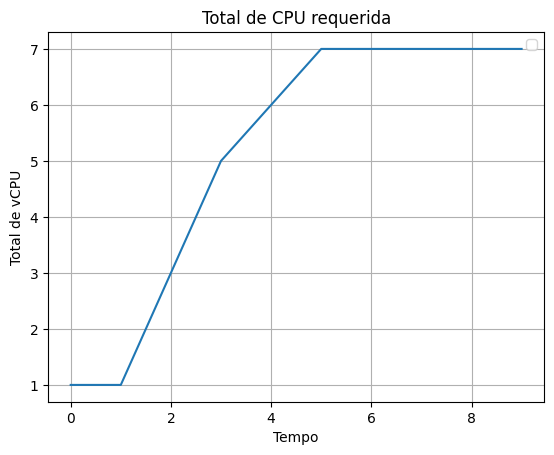

In [ ]:
#
fig, ax = plt.subplots()
ax.plot(t, aggregate_total_required_vcpu_osn, label='')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida')
plt.legend()
plt.show()

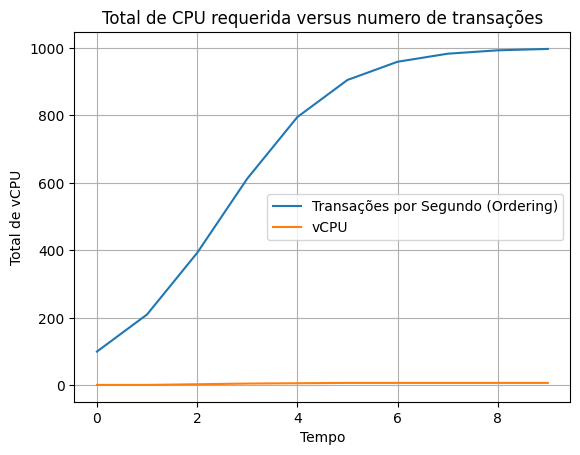

In [ ]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()

plt.plot(t, ordering_transations, label='Transações por Segundo (Ordering)')
plt.plot(t, aggregate_total_required_vcpu_osn, label='vCPU')


ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida versus numero de transações')
plt.legend()
plt.show()

## CPU PEER

In [ ]:
aggregate_total_required_vcpu_peer = np.array([])
vCPU_BASE     =  2
vCPU_BASE_TPS = 200 # 2vcpu = 200

peer_commited_transations = AVG_RATE_TRANSACTIONS
peer_endorsement_transations = AVG_RATE_TRANSACTIONS * ENDORSEMENT_POLICY
peer_endorsement_commited_transations = peer_commited_transations + peer_endorsement_transations

for tps in peer_endorsement_commited_transations:
    target_required_vcpu  = vCPU_BASE

    required_vcpu_current_tps = tps / vCPU_BASE_TPS

    if int(required_vcpu_current_tps) > 1:
        target_required_vcpu = vCPU_BASE + (vCPU_BASE * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_peer = np.append(aggregate_total_required_vcpu_peer, target_required_vcpu)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


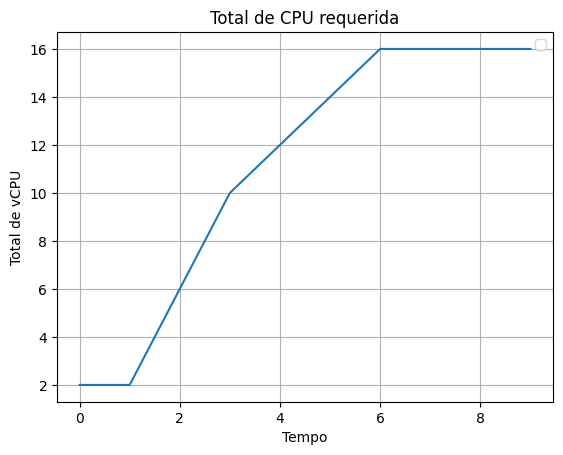

In [ ]:
#
fig, ax = plt.subplots()
ax.plot(t, aggregate_total_required_vcpu_peer, label='')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida')
plt.legend()
plt.show()

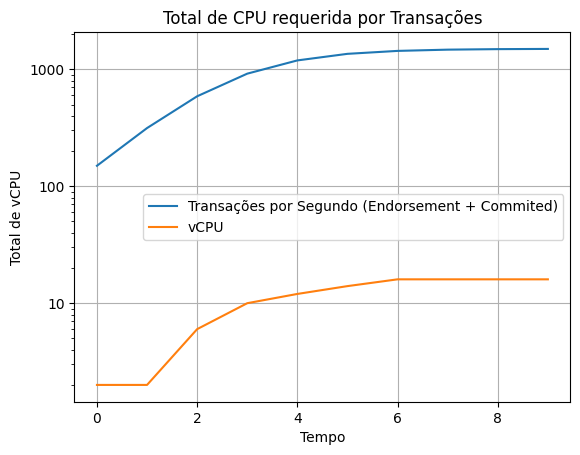

In [ ]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()

plt.semilogy(t, peer_endorsement_commited_transations, label='Transações por Segundo (Endorsement + Commited)')
plt.plot(t, aggregate_total_required_vcpu_peer, label='vCPU')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida por Transações')
plt.legend()
plt.show()

# Cloud Costs

In [ ]:
# EC2
df = pd.read_csv('Amazon EC2 Instance Comparison.csv')
df['vCPUs'] = df['vCPUs'].str.replace(r'\D+', '', regex=True)
df['On Demand'] = df['On Demand'].str.replace(r'[^0-9.]', '', regex=True)

df['vCPUs'] = pd.to_numeric(df['vCPUs'])
df['On Demand'] = pd.to_numeric(df['On Demand'])

#instancias = df[(df['vCPUs'] > aggregate_total_required_vcpu_peer)]

In [ ]:
df

,Name,API Name,Instance Memory,vCPUs,Instance Storage,Network Performance,On Demand,Linux Reserved cost,Linux Spot Minimum cost,Windows On Demand cost,Windows Reserved cost
0,C6A Large,c6a.large,4.0 GiB,2,EBS only,Up to 12.5 Gigabit,0.0765,$0.0506 hourly,$0.0388 hourly,$0.1685 hourly,$0.1426 hourly
1,C6A Extra Large,c6a.xlarge,8.0 GiB,4,EBS only,Up to 12.5 Gigabit,0.1530,$0.1012 hourly,$0.0769 hourly,$0.3370 hourly,$0.2852 hourly
2,C6A Double Extra Large,c6a.2xlarge,16.0 GiB,8,EBS only,Up to 12.5 Gigabit,0.3060,$0.2024 hourly,$0.1520 hourly,$0.6740 hourly,$0.5704 hourly
3,C6A Quadruple Extra Large,c6a.4xlarge,32.0 GiB,16,EBS only,Up to 12.5 Gigabit,0.6120,$0.4048 hourly,$0.3186 hourly,$1.3480 hourly,$1.1408 hourly
4,C6A Eight Extra Large,c6a.8xlarge,64.0 GiB,32,EBS only,12.5 Gigabit,1.2240,$0.8097 hourly,$0.6129 hourly,$2.6960 hourly,$2.2817 hourly
5,C6A 12xlarge,c6a.12xlarge,96.0 GiB,48,EBS only,18.75 Gigabit,1.8360,$1.2145 hourly,$0.8785 hourly,$4.0440 hourly,$3.4225 hourly
6,C6A 16xlarge,c6a.16xlarge,128.0 GiB,64,EBS only,25 Gigabit,2.4480,$1.6194 hourly,$1.1709 hourly,$5.3920 hourly,$4.5633 hourly
7,C6A 24xlarge,c6a.24xlarge,192.0 GiB,96,EBS only,37.5 Gigabit,3.6720,$2.4290 hourly,$1.6719 hourly,$8.0880 hourly,$6.8450 hourly
8,C6A 32xlarge,c6a.32xlarge,256.0 GiB,128,EBS only,50 Gigabit,4.8960,$3.2387 hourly,$2.2912 hourly,$10.7840 hourly,$9.1267 hourly
9,C6A 48xlarge,c6a.48xlarge,384.0 GiB,192,EBS only,50 Gigabit,7.3440,$4.8581 hourly,$3.3435 hourly,$16.1760 hourly,$13.6901 hourly


In [ ]:
def provisioned_instance_types(required_vcpu):
    provisioned_vcpu = np.array([])

    # Iterar sobre os elementos do array
    for vcpu in required_vcpu:
        # Verificar se o valor existe na coluna do DataFrame
        if vcpu in df['vCPUs'].values:
            # Se existir, adiciona o valor ao novo array
            type = df[(df['vCPUs'] == vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, type)
        else:
            # Se não existir, pega o valor mais próximo na coluna do DataFrame
            next_type = df[(df['vCPUs'] > vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, next_type)

    return provisioned_vcpu

In [ ]:
provisioned_instance_peer = provisioned_instance_types(aggregate_total_required_vcpu_peer)
provisioned_instance_osn = provisioned_instance_types(aggregate_total_required_vcpu_osn)

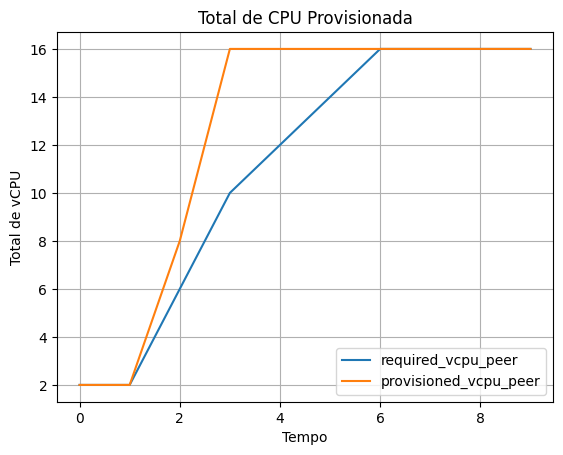

In [ ]:
fig, ax = plt.subplots()

ax.plot(t, aggregate_total_required_vcpu_peer, label='required_vcpu_peer')

plot_provisioned_instance_peer = [x['vCPUs'] for x in provisioned_instance_peer]

ax.plot(t, plot_provisioned_instance_peer, label='provisioned_vcpu_peer')


ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU Provisionada')
plt.legend()
plt.show()

In [ ]:
def convert_period_hours(predict_type):
    
    return {
    'DAY': 24,
    'WEEK': 730 / 4,
    'MONTH': 730, # Providers consideram 730 por mes
    'YEAR': 730 * 12
    }[predict_type]

period_hours = convert_period_hours(PREDICT_TYPE)

cost_provisioned_instance_peer =  np.array([x['On Demand'] for x in provisioned_instance_peer])
cost_provisioned_instance_osn =  np.array([x['On Demand'] for x in provisioned_instance_osn])


computer_cost_period_peer   = cost_provisioned_instance_peer    * period_hours
computer_cost_period_osn    = cost_provisioned_instance_osn     * period_hours


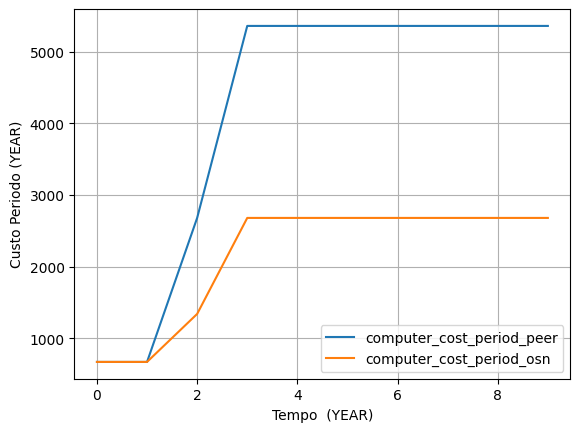

In [ ]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, computer_cost_period_peer, label='computer_cost_period_peer')
plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [ ]:
total_computer_cost_period = computer_cost_period_peer + computer_cost_period_osn

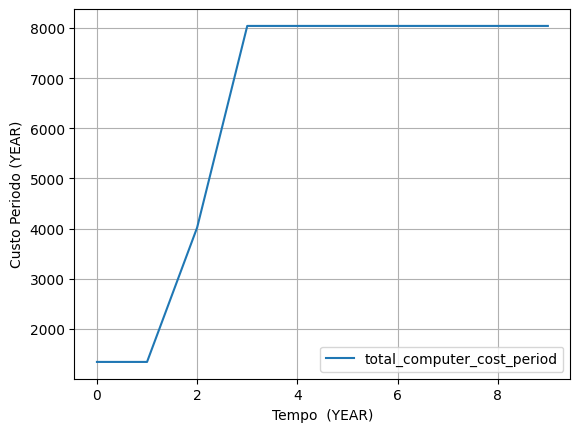

In [ ]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_computer_cost_period, label='total_computer_cost_period')



ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

# Network

Considera que o peer e o ordering service estão na mesma rede </br>
pacotes de ack são desconsiderados Ex.: Code 200

In [ ]:
transaction_size_gb                 = blockchain_predict.transation_size / BYTE_TO_GIGA
estimate_transaction_network_cost   = predict.CostPredict().network_throughput_pricing * transaction_size_gb

network_tput_cost_clients_to_endorsement_peer   =  endorsement_transations * estimate_transaction_network_cost
network_tput_cost_clients_to_ordering_server    =  total_transactions_by_period * estimate_transaction_network_cost


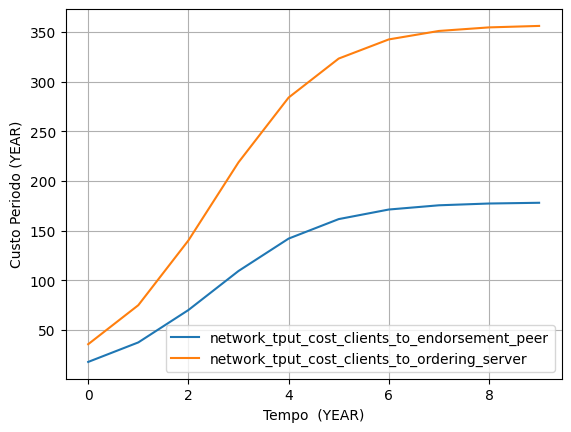

In [ ]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, network_tput_cost_clients_to_endorsement_peer, label='network_tput_cost_clients_to_endorsement_peer')
plt.plot(t, network_tput_cost_clients_to_ordering_server, label='network_tput_cost_clients_to_ordering_server')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [ ]:
total_network_throuput_cost = network_tput_cost_clients_to_ordering_server + network_tput_cost_clients_to_endorsement_peer


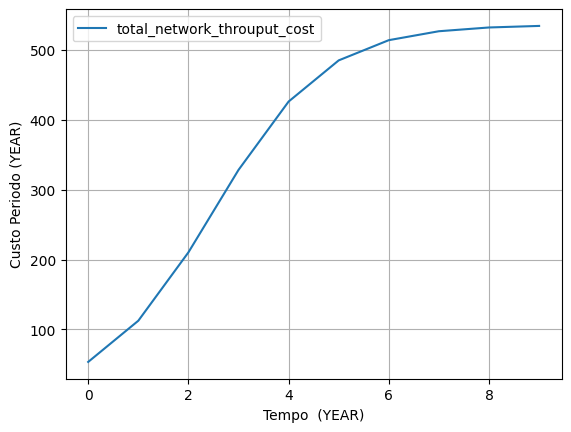

In [ ]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_network_throuput_cost, label='total_network_throuput_cost')

ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()


# CUSTOS TOTAL

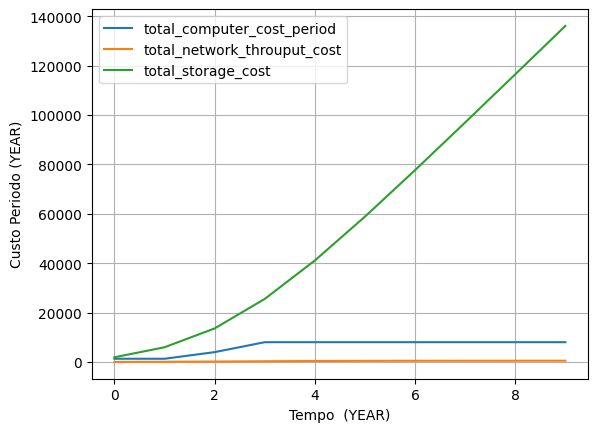

In [ ]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_computer_cost_period, label='total_computer_cost_period')
plt.plot(t, total_network_throuput_cost, label='total_network_throuput_cost')
plt.plot(t, total_storage_cost, label='total_storage_cost')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [ ]:
total_cost = total_computer_cost_period + total_network_throuput_cost + total_storage_cost

In [ ]:
total_cost[-1]

144641.36425360417

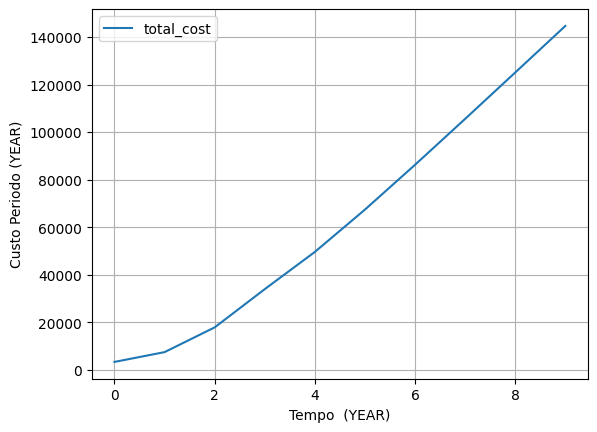

In [ ]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_cost, label='total_cost')



ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

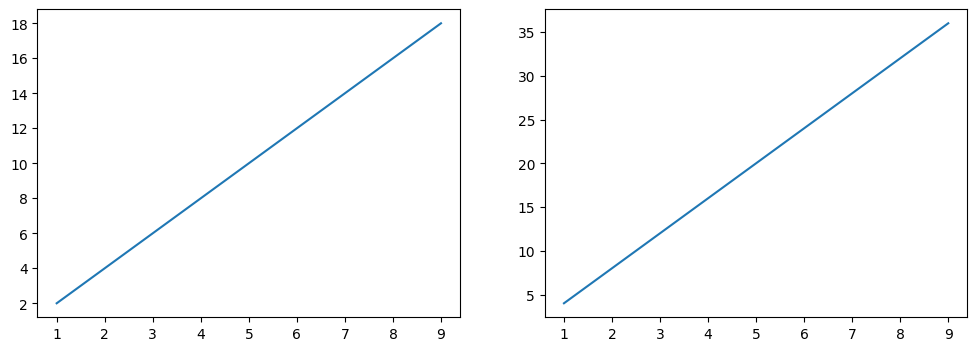

In [ ]:
x = np.arange(1,10)
y = x *2 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
ax1.plot(x,y)

y = x *4 
ax2.plot(x,y)

plt.show()
